# Goldenspike: an example of an end-to-end analysis using RAIL

**Authors:** Sam Schmidt, Eric Charles, Alex Malz, John Franklin Crenshaw, others...

**Last run successfully:** Oct 23, 2023


This notebook demonstrates how to use a the various RAIL Modules to draw synthetic samples of fluxes by color, apply physical effects to them, train photo-Z estimators on the samples, test and validate the preformance of those estimators, and to use the RAIL summarization modules to obtain n(z) estimates based on the p(z) estimates.

**Creation** 

Note that in the parlance of the Creation Module, "degradation" is any post-processing that occurs to the "true" sample generated by the create Engine.  This can include adding photometric errors, applying quality cuts, introducing systematic biases, etc. 

In this notebook, we will draw both test and training samples from a RAIL Engine object. Then we will demonstrate how to use RAIL degraders to apply effects to those samples.

**Training and Estimation** 

The RAIL Informer modules "train" or "inform" models used to estimate p(z) given band fluxes (and potentially other information).

The RAIL Estimation modules then use those same models to actually apply the model and extract the p(z) estimates.

**p(z) Validation** 

The RAIL Validator module applies various metrics.

**p(z) to n(z) Summarization** 

The RAIL Summarization modules convert per-galaxy p(z) posteriors to ensemble n(z) estimates. 

##  Imports

In [1]:
# Prerquisites: os, numpy, pathlib, pzflow, tables_io
import os
import numpy as np
from pathlib import Path
from collections import OrderedDict
from pzflow.examples import get_galaxy_data
import tables_io


In [2]:
# Various rail modules
import rail
from rail.creation.degraders.photometric_errors import LSSTErrorModel
from rail.creation.degraders.spectroscopic_degraders import (
    InvRedshiftIncompleteness,
    LineConfusion,
)
from rail.creation.degraders.quantityCut import QuantityCut
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle, Hdf5Handle
from rail.core.stage import RailStage
from rail.tools.table_tools import ColumnMapper, TableConverter

from rail.estimation.algos.bpz_lite import BPZliteInformer, BPZliteEstimator
from rail.estimation.algos.k_nearneigh import KNearNeighInformer, KNearNeighEstimator
from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator

from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer

from rail.evaluation.dist_to_point_evaluator import DistToPointEvaluator



RAIL now uses ceci as a back-end, which takes care of a lot of file I/O decisions to be consistent with other choices in DESC.

The data_store commands in the cell below effectively override a ceci default to prevent overwriting previous results, generally good but not necessary for this demo.

The `DataStore` uses `DataHandle` objects to keep track of the connections between the various stages.  When one stage returns a `DataHandle` and then you pass that `DataHandle` to another stage, the underlying code can establish the connections needed to build a reproducilble pipeline.   

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True


Here we need a few configuration parameters to deal with differences in data schema between existing PZ codes.

In [4]:
bands = ["u", "g", "r", "i", "z", "y"]
band_dict = {band: f"mag_{band}_lsst" for band in bands}
rename_dict = {f"mag_{band}_lsst_err": f"mag_err_{band}_lsst" for band in bands}


## Train the Flow Engine

First we need to train the normalizing flow that will serve as the engine for the notebook.

In the cell below, we load the example galaxy catalog from PZFlow and save it so that it can be used to train the flow. We also set the path where we will save the flow.

In [5]:
DATA_DIR = Path().resolve() / "data"
DATA_DIR.mkdir(exist_ok=True)

catalog_file = DATA_DIR / "base_catalog.pq"
catalog = get_galaxy_data().rename(band_dict, axis=1)
tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

catalog_file = str(catalog_file)
flow_file = str(DATA_DIR / "trained_flow.pkl")


Now we set the parameters for the FlowModeler, i.e. the pipeline stage that trains the flow:

In [6]:
flow_modeler_params = {
    "name": "flow_modeler",
    "input": catalog_file,
    "model": flow_file,
    "seed": 0,
    "phys_cols": {"redshift": [0, 3]},
    "phot_cols": {
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    "calc_colors": {"ref_column_name": "mag_i_lsst"},
}


Now we will create the flow and train it

In [7]:
flow_modeler = FlowModeler.make_stage(**flow_modeler_params)


In [8]:
flow_modeler.fit_model()


Created Handle.  input: /Users/echarles/software/DESC/rail/examples/goldenspike_examples/data/base_catalog.pq, flow_modeler
column_list None
Training 30 epochs 
Loss:
(0) 17.6137
(1) 2.9725
(2) -0.7222
(3) -0.4412
(4) -1.6240
(5) -1.6453
(6) -1.5866
(7) -1.7476
(8) -2.8166
(9) -2.2542
(10) -3.1394
(11) -3.2340
(12) -3.6035
(13) -2.1231
(14) -2.3571
(15) -2.0465
(16) -4.1089
(17) -3.1462
(18) -2.4698
(19) -4.1372
(20) -3.9973
(21) -4.3600
(22) -2.4264
(23) -3.7504
(24) -3.8707
(25) -3.5970
(26) -3.7790
(27) -2.8135
(28) -4.8004
(29) -4.0519
(30) -4.8362
Created Handle.  model_flow_modeler: /Users/echarles/software/DESC/rail/examples/goldenspike_examples/data/inprogress_trained_flow.pkl, flow_modeler


## Make mock data

Now we will use the trained flow to create training and test data for the photo-z estimators.

For both the training and test data we will:

1. Use the Flow to produce some synthetic data
2. Use the LSSTErrorModel to add photometric errors
3. Use the FlowPosterior to estimate the redshift posteriors for the degraded sample
4. Use the ColumnMapper to rename the error columns so that they match the names in DC2.
5. Use the TableConverter to convert the data to a numpy dictionary, which will be stored in a hdf5 file with the same schema as the DC2 data

### Training sample

For the training data we are going to apply a couple of extra degradation effects to the data beyond what we do to create test data, as the training data will have some spectroscopic incompleteness.  This will allow us to see how the trained models perform with imperfect training data.

More details about the degraders are available in the `rail/examples/creation_examples/degradation_demo.ipynb` notebook.


In [9]:
flow_creator_train = FlowCreator.make_stage(
    name="flow_creator_train",
    model=flow_modeler.get_handle("model"),
    n_samples=50,
    seed=1235,
)

lsst_error_model_train = LSSTErrorModel.make_stage(
    name="lsst_error_model_train",
    renameDict=band_dict,
    ndFlag=np.nan,
    seed=29,
)

inv_redshift = InvRedshiftIncompleteness.make_stage(
    name="inv_redshift",
    pivot_redshift=1.0,
)

line_confusion = LineConfusion.make_stage(
    name="line_confusion",
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed = 1337
)

quantity_cut = QuantityCut.make_stage(
    name="quantity_cut",
    cuts={"mag_i_lsst": 25.0},
)

col_remapper_train = ColumnMapper.make_stage(
    name="col_remapper_train",
    columns=rename_dict,
)

table_conv_train = TableConverter.make_stage(
    name="table_conv_train",
    output_format="numpyDict",
)


In [10]:
train_data_orig = flow_creator_train.sample(150, 1235)
train_data_errs = lsst_error_model_train(train_data_orig, seed=66)
train_data_inc = inv_redshift(train_data_errs)
train_data_conf = line_confusion(train_data_inc)
train_data_cut = quantity_cut(train_data_conf)
train_data_pq = col_remapper_train(train_data_cut)
train_data = table_conv_train(train_data_pq)


Created Handle.  output_flow_creator_train: inprogress_output_flow_creator_train.pq, flow_creator_train
Created Handle.  output_lsst_error_model_train: inprogress_output_lsst_error_model_train.pq, lsst_error_model_train
Created Handle.  output_inv_redshift: inprogress_output_inv_redshift.pq, inv_redshift
Created Handle.  output_line_confusion: inprogress_output_line_confusion.pq, line_confusion
Created Handle.  output_quantity_cut: inprogress_output_quantity_cut.pq, quantity_cut
Created Handle.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Created Handle.  output_table_conv_train: inprogress_output_table_conv_train.hdf5, table_conv_train


Let's examine the quantities that we've generated, we'll use the handy `tables_io` package to temporarily write to a pandas dataframe for quick writeout of the columns:

In [11]:
train_table = tables_io.convertObj(train_data.data, tables_io.types.PD_DATAFRAME)
train_table.head()


,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,0.941798,26.468237,0.367821,26.538981,0.143218,24.937027,0.030757,23.843440,0.019286,22.969629,0.017155,22.615381,0.027795
1,1.284789,24.947141,0.103405,24.670860,0.027747,24.117668,0.015313,23.720556,0.017402,23.345853,0.023590,22.955750,0.037501
2,0.138555,25.486282,0.164562,24.766372,0.030158,24.642631,0.023792,24.392329,0.030995,24.666693,0.075658,24.589608,0.157649
3,0.574592,26.386970,0.345124,26.432003,0.130597,25.290146,0.042019,24.654337,0.039063,24.594748,0.070995,24.214217,0.113990
4,0.299697,26.681380,0.433359,25.566312,0.061112,24.937577,0.030772,24.772263,0.043368,24.376485,0.058509,24.347623,0.127998


You see that we've generated redshifts, ugrizy magnitudes, and magnitude errors with names that match those in the cosmoDC2_v1.1.4_image data.

### Testing sample

For the test sample we will:

1. Use the Flow to produce some synthetic data
2. Use the LSSTErrorModel to smear the data
3. Use the FlowPosterior to estimate the redshift posteriors for the degraded sample
4. Use ColumnMapper to rename some of the columns to match DC2
5. Use the TableConverter to convert the data to a numpy dictionary, which will be stored in a hdf5 file with the same schema as the DC2 data

In [12]:
flow_creator_test = FlowCreator.make_stage(
    name="flow_creator_test",
    model=flow_modeler.get_handle("model"),
    n_samples=50,
)

lsst_error_model_test = LSSTErrorModel.make_stage(
    name="lsst_error_model_test",
    renameDict=band_dict,
    ndFlag=np.nan,
)

flow_post_test = FlowPosterior.make_stage(
    name="flow_post_test",
    model=flow_modeler.get_handle("model"),
    column="redshift",
    grid=np.linspace(0.0, 5.0, 21),
)

col_remapper_test = ColumnMapper.make_stage(
    name="col_remapper_test",
    columns=rename_dict,
    hdf5_groupname="",
)

table_conv_test = TableConverter.make_stage(
    name="table_conv_test",
    output_format="numpyDict",
)


In [13]:
test_data_orig = flow_creator_test.sample(150, 1234)
test_data_errs = lsst_error_model_test(test_data_orig, seed=58)
test_data_post = flow_post_test.get_posterior(test_data_errs, err_samples=None)
test_data_pq = col_remapper_test(test_data_errs)
test_data = table_conv_test(test_data_pq)


Created Handle.  output_flow_creator_test: inprogress_output_flow_creator_test.pq, flow_creator_test
Created Handle.  output_lsst_error_model_test: inprogress_output_lsst_error_model_test.pq, lsst_error_model_test
Created Handle.  output_flow_post_test: inprogress_output_flow_post_test.hdf5, flow_post_test
Created Handle.  output_col_remapper_test: inprogress_output_col_remapper_test.pq, col_remapper_test
Created Handle.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


/Users/echarles/software/DESC/qp/src/qp/parameterizations/interp/interp.py:187: UserWarning: The distributions at indices = [ 73 105 139 144 145] have an integral of 0.
  warnings.warn(
/Users/echarles/software/DESC/qp/src/qp/parameterizations/interp/interp.py:207: RuntimeWarning: invalid value encountered in divide
  new_yvals = (self._yvals.T / self._ycumul[:, -1]).T
/Users/echarles/software/DESC/qp/src/qp/parameterizations/interp/interp.py:208: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T
/Users/echarles/software/DESC/qp/src/qp/parameterizations/interp/interp.py:140: RuntimeWarning: There are non-finite values in the yvals for the following distributions: (array([ 73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,
        73,  73,  73,  73,  73,  73,  73,  73, 105, 105, 105, 105, 105,
       105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
       105, 105, 105, 139, 139, 139, 139, 139, 139,

In [14]:
test_data_handle = Hdf5Handle('input')
od = OrderedDict()
od['photometry'] = test_data_orig.data.to_records()
test_data_handle.set_data(od)
test_data_handle.path  = './test_data_orig.hdf5'
test_data_handle.write()

'./test_data_orig.hdf5'

In [15]:
test_table = tables_io.convertObj(test_data.data, tables_io.types.PD_DATAFRAME)
test_table.head()


,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,0.319266,26.514193,0.381204,25.563703,0.060971,24.975950,0.031828,24.811882,0.044920,24.525358,0.066765,24.565784,0.154467
1,0.744365,23.628902,0.032559,22.894952,0.007524,22.061959,0.005526,21.131251,0.005285,20.801679,0.005552,20.579419,0.006665
2,0.237539,NaN,NaN,27.974578,0.460246,27.206477,0.223053,27.043196,0.306857,28.031491,1.034558,26.724489,0.813140
3,1.700580,27.370854,0.711125,26.170900,0.104075,25.439896,0.047991,24.730186,0.041779,24.165623,0.048522,24.023536,0.096485
4,0.504657,NaN,NaN,26.666050,0.159698,25.695064,0.060192,25.039636,0.054988,24.654096,0.074820,24.456978,0.140681


## "Inform" some estimators

More details about the process of "informing" or "training" the models used by the estimators is available in the `rail/examples/estimation_examples/RAIL_estimation_demo.ipynb` notebook.

We use "inform" rather than "train" to generically refer to the preprocessing of any prior information.
For a machine learning estimator, that prior information is a training set, but it can also be an SED template library for a template-fitting or hybrid estimator.

In [16]:
inform_bpz = BPZliteInformer.make_stage(
    name="inform_bpz",
    nondetect_val=np.nan,
    model="bpz.pkl",
    hdf5_groupname="",
)

inform_knn = KNearNeighInformer.make_stage(
    name="inform_knn",
    nondetect_val=np.nan,
    model="knnpz.pkl",
    hdf5_groupname="",
)

inform_fzboost = FlexZBoostInformer.make_stage(
    name="inform_FZBoost",
    nondetect_val=np.nan,
    model="fzboost.pkl",
    hdf5_groupname="",
)


In [17]:
train_data_errs.data.keys()

Index(['redshift', 'mag_u_lsst', 'mag_u_lsst_err', 'mag_g_lsst',
       'mag_g_lsst_err', 'mag_r_lsst', 'mag_r_lsst_err', 'mag_i_lsst',
       'mag_i_lsst_err', 'mag_z_lsst', 'mag_z_lsst_err', 'mag_y_lsst',
       'mag_y_lsst_err'],
      dtype='object')

In [18]:
inform_bpz.inform(train_data)
inform_knn.inform(train_data)
inform_fzboost.inform(train_data)


using 63 galaxies in calculation
best values for fo and kt:
[1.]
[0.3]
minimizing for type 0
best fit z0, alpha, km for type 0: [0.33877801 1.9676512  0.08868376]
Created Handle.  model_inform_bpz: inprogress_bpz.pkl, inform_bpz
split into 47 training and 16 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.075 and numneigh=4



Created Handle.  model_inform_knn: inprogress_knnpz.pkl, inform_knn
stacking some data...
read in training data
fit the model...


/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are

finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...
Created Handle.  model_inform_FZBoost: inprogress_fzboost.pkl, inform_FZBoost


/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:35:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "silent" } are

## Estimate photo-z posteriors

More detail on the specific estimators used here is available in the `rail/examples/estimation_examples/RAIL_estimation_demo.ipynb` notebook, but here is a very brief summary of the three estimators used in this notebook:

`BPZliteEstimator` is a template-based photo-z code that outputs the posterior estimated given likelihoods calculated using a template set combined with a Bayesian prior. See Benitez (2000) for more details.<br>
`KNearNeighEstimator` is a simple photo-z code that finds the K nearest neighbor training galaxies in color/magnitude space and creates a weighted (by distance) mixture model PDF based on the redshifts of those K neighbors.<br>
`FlexZBoostEstimator` is a mature photo-z algorithm that estimates a PDF for each galaxy via a conditional density estimate using the training data.  See [Izbicki & Lee (2017)](https://doi.org/10.1214/17-EJS1302) for more details.<br>


In [19]:
estimate_bpz = BPZliteEstimator.make_stage(
    name="estimate_bpz",
    hdf5_groupname="",
    nondetect_val=np.nan,
    model=inform_bpz.get_handle("model"),
)

estimate_knn = KNearNeighEstimator.make_stage(
    name="estimate_knn",
    hdf5_groupname="",
    nondetect_val=np.nan,
    model=inform_knn.get_handle("model"),
)

estimate_fzboost = FlexZBoostEstimator.make_stage(
    name="test_FZBoost",
    nondetect_val=np.nan,
    model=inform_fzboost.get_handle("model"),
    hdf5_groupname="",
    aliases=dict(input="test_data", output="fzboost_estim"),
)


In [20]:
knn_estimated = estimate_knn.estimate(test_data)
fzboost_estimated = estimate_fzboost.estimate(test_data)
bpz_estimated = estimate_bpz.estimate(test_data)


Process 0 running estimator on chunk 0 - 150
Process 0 estimating PZ PDF for rows 0 - 150
Created Handle.  output_estimate_knn: inprogress_output_estimate_knn.hdf5, estimate_knn
Process 0 running estimator on chunk 0 - 150
Process 0 estimating PZ PDF for rows 0 - 150
Created Handle.  output_test_FZBoost: inprogress_output_test_FZBoost.hdf5, test_FZBoost
Process 0 running estimator on chunk 0 - 150
Created Handle.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


## Evaluate the estimates

Now we evaluate metrics on the estimates, separately for each estimator.  

Each call to the `Evaluator.evaluate` will create a table with the various performance metrics. 
We will store all of these tables in a dictionary, keyed by the name of the estimator.

In [21]:
ztrue_file = './test_data_orig.hdf5'
ztrue_data = DS.read_file('ztrue_data', TableHandle, ztrue_file)


In [22]:
eval_dict = dict(bpz=bpz_estimated, fzboost=fzboost_estimated, knn=knn_estimated)

evaluator_stage_dict = dict(
    metrics=['cdeloss', 'pit', 'brier'],
    _random_state=None,
    metric_config={
        'brier': {'limits':(0,3.1)},
        'pit':{'tdigest_compression': 1000},
    }
)
truth = ztrue_data

result_dict = {}
for key, val in eval_dict.items():
    the_eval = DistToPointEvaluator.make_stage(name=f'{key}_dist_to_point', force_exact=True, **evaluator_stage_dict)
    result_dict[key] = the_eval.evaluate(val, truth)
    
    
    


Requested metrics: ['cdeloss', 'pit', 'brier']
Created Handle.  output_bpz_dist_to_point: inprogress_output_bpz_dist_to_point.hdf5, bpz_dist_to_point
Created Handle.  summary_bpz_dist_to_point: inprogress_summary_bpz_dist_to_point.hdf5, bpz_dist_to_point
Created Handle.  single_distribution_summary_bpz_dist_to_point: inprogress_single_distribution_summary_bpz_dist_to_point.hdf5, bpz_dist_to_point
Requested metrics: ['cdeloss', 'pit', 'brier']
Created Handle.  output_fzboost_dist_to_point: inprogress_output_fzboost_dist_to_point.hdf5, fzboost_dist_to_point
Created Handle.  summary_fzboost_dist_to_point: inprogress_summary_fzboost_dist_to_point.hdf5, fzboost_dist_to_point
Created Handle.  single_distribution_summary_fzboost_dist_to_point: inprogress_single_distribution_summary_fzboost_dist_to_point.hdf5, fzboost_dist_to_point
Requested metrics: ['cdeloss', 'pit', 'brier']


Created Handle.  output_knn_dist_to_point: inprogress_output_knn_dist_to_point.hdf5, knn_dist_to_point
Created Handle.  summary_knn_dist_to_point: inprogress_summary_knn_dist_to_point.hdf5, knn_dist_to_point
Created Handle.  single_distribution_summary_knn_dist_to_point: inprogress_single_distribution_summary_knn_dist_to_point.hdf5, knn_dist_to_point


In [23]:
result_dict

{'bpz': {'output': <rail.core.handle.Hdf5Handle at 0x3476c7950>,
  'summary': <rail.core.handle.Hdf5Handle at 0x34700f950>,
  'single_distribution_summary': <rail.core.handle.QPDictHandle at 0x34700a510>},
 'fzboost': {'output': <rail.core.handle.Hdf5Handle at 0x34701dfd0>,
  'summary': <rail.core.handle.Hdf5Handle at 0x347028f30>,
  'single_distribution_summary': <rail.core.handle.QPDictHandle at 0x347027b10>},
 'knn': {'output': <rail.core.handle.Hdf5Handle at 0x347029590>,
  'summary': <rail.core.handle.Hdf5Handle at 0x347064650>,
  'single_distribution_summary': <rail.core.handle.QPDictHandle at 0x347024f50>}}

The Pandas DataFrame output format conveniently makes human-readable printouts of the metrics.  
This next cell will convert everything to Pandas.

In [24]:
results_tables = {
    key: tables_io.convertObj(val['summary'].data, tables_io.types.PD_DATAFRAME)
    for key, val in result_dict.items()
}


In [25]:
results_tables["knn"]


,cdeloss,brier
0,-0.89562,204.223539


In [26]:
results_tables["fzboost"]


,cdeloss,brier
0,2.64433,536.724685


In [27]:
results_tables["bpz"]


,cdeloss,brier
0,-0.981894,165.412674


## Summarize the per-galaxy redshift constraints to make population-level distributions

{introduce the summarizers}

First we make the stages, then execute them, then plot the output.

In [28]:
point_estimate_test = PointEstHistSummarizer.make_stage(name="point_estimate_test")
naive_stack_test = NaiveStackSummarizer.make_stage(name="naive_stack_test")


In [29]:
point_estimate_ens = point_estimate_test.summarize(eval_dict["bpz"])
naive_stack_ens = naive_stack_test.summarize(eval_dict["bpz"])


Process 0 running estimator on chunk 0 - 150
Created Handle.  output_point_estimate_test: inprogress_output_point_estimate_test.hdf5, point_estimate_test
Created Handle.  single_NZ_point_estimate_test: inprogress_single_NZ_point_estimate_test.hdf5, point_estimate_test
Process 0 running estimator on chunk 0 - 150
Created Handle.  output_naive_stack_test: inprogress_output_naive_stack_test.hdf5, naive_stack_test
Created Handle.  single_NZ_naive_stack_test: inprogress_single_NZ_naive_stack_test.hdf5, naive_stack_test


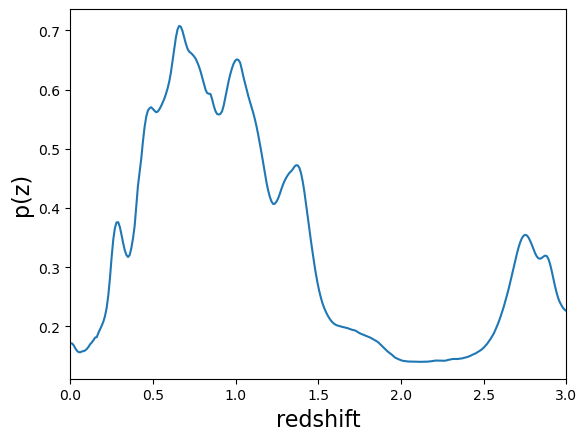

In [30]:
_ = naive_stack_ens.data.plot_native(xlim=(0, 3))


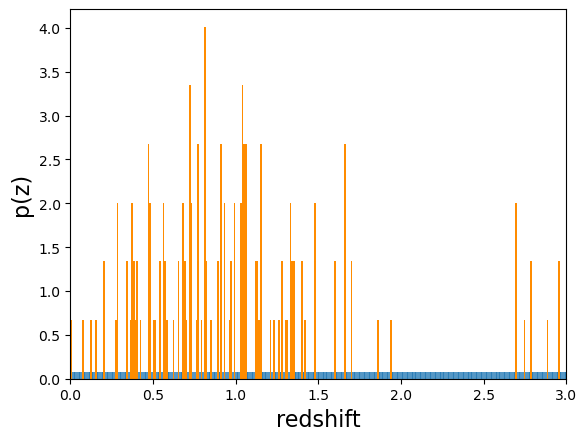

In [31]:
_ = point_estimate_ens.data.plot_native(xlim=(0, 3))


## Convert this to a `ceci` Pipeline

Now that we have all these stages defined and configured, and that we have established the connections between them by passing `DataHandle` objects between them, we can build a `ceci` Pipeline.


In [32]:
import ceci

pipe = ceci.Pipeline.interactive()
stages = [
    # train the flow
    flow_modeler,
    # create the training catalog
    flow_creator_train,
    lsst_error_model_train,
    inv_redshift,
    line_confusion,
    quantity_cut,
    col_remapper_train,
    table_conv_train,
    # create the test catalog
    flow_creator_test,
    lsst_error_model_test,
    col_remapper_test,
    table_conv_test,
    # inform the estimators
    inform_bpz,
    inform_knn,
    inform_fzboost,
    # estimate posteriors
    estimate_bpz,
    estimate_knn,
    estimate_fzboost,
    # estimate n(z), aka "summarize"
    point_estimate_test,
    naive_stack_test,
]
for stage in stages:
    pipe.add_stage(stage)


In [33]:
pipe.initialize(
    dict(input=catalog_file), dict(output_dir=".", log_dir=".", resume=False), None
)


(({'flow_modeler': <Job flow_modeler>,
   'flow_creator_train': <Job flow_creator_train>,
   'flow_creator_test': <Job flow_creator_test>,
   'lsst_error_model_train': <Job lsst_error_model_train>,
   'lsst_error_model_test': <Job lsst_error_model_test>,
   'inv_redshift': <Job inv_redshift>,
   'col_remapper_test': <Job col_remapper_test>,
   'line_confusion': <Job line_confusion>,
   'table_conv_test': <Job table_conv_test>,
   'quantity_cut': <Job quantity_cut>,
   'col_remapper_train': <Job col_remapper_train>,
   'table_conv_train': <Job table_conv_train>,
   'inform_bpz': <Job inform_bpz>,
   'inform_knn': <Job inform_knn>,
   'inform_FZBoost': <Job inform_FZBoost>,
   'estimate_bpz': <Job estimate_bpz>,
   'estimate_knn': <Job estimate_knn>,
   'test_FZBoost': <Job test_FZBoost>,
   'point_estimate_test': <Job point_estimate_test>,
   'naive_stack_test': <Job naive_stack_test>},
   Stage that applies remaps the following column names in a pandas DataFrame:
   f{str(self.config.c

In [34]:
pipe.save("tmp_goldenspike.yml")


### Read back the pipeline and run it

In [35]:
pr = ceci.Pipeline.read("tmp_goldenspike.yml")


Created Handle.  model_flow_modeler: /Users/echarles/software/DESC/rail/examples/goldenspike_examples/data/trained_flow.pkl, flow_creator_train
Created Handle.  model_flow_modeler: /Users/echarles/software/DESC/rail/examples/goldenspike_examples/data/trained_flow.pkl, flow_creator_test


In [36]:
pr.run()



Executing flow_modeler
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowModeler   --input=/Users/echarles/software/DESC/rail/examples/goldenspike_examples/data/base_catalog.pq   --name=flow_modeler   --config=tmp_goldenspike_config.yml   --model=.//Users/echarles/software/DESC/rail/examples/goldenspike_examples/data/trained_flow.pkl 
Output writing to ./flow_modeler.out

Job flow_modeler has completed successfully in 57.1 seconds seconds !

Executing flow_creator_train
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=.//Users/echarles/software/DESC/rail/examples/goldenspike_examples/data/trained_flow.pkl   --name=flow_creator_train   --config=tmp_goldenspike_config.yml   --output=./output_flow_creator_train.pq 
Output writing to ./flow_creator_train.out

Job flow_creator_train has completed successfully in 6.0 seconds seconds !

Executing flow_creator_test
Command is:
OMP_NUM_THREADS=1   python3 

0

## Clean up:

Finally, you'll notice that we've written a large number of temporary files in the course of running this demo, to delete these and clean up the directory just run the `cleanup.sh` script in this directory to delete the data files.

In [37]:
# TODO fix and add clean up scripts
